# Preliminaries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import TSNE

from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,  davies_bouldin_score
from scipy.spatial.distance import cdist
from kneed import KneeLocator

from tqdm import tqdm

In [3]:
! pip install kneed

In [4]:
! pip install yellowbrick

# Data Preprocessing

In [5]:
df = pd.read_csv('C:\\Users\\berna\\Documents\\Eskwelabs\\Capstone Project\\consolidated_csv_03STA-RI_G03.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,06/26/2021,RTD,CLUZ,SLUZON,03STA-RI_G03,06/26/2021 12:05:00 AM,06/26/2021,06/26/2021 12:05:00 AM,FGPCSTRA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,RTD,CLUZ,SLUZON,03STA-RI_G03,06/26/2021 12:10:00 AM,06/26/2021 12:05:00 AM,06/26/2021 12:10:00 AM,FGPCSTRA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,RTD,CLUZ,SLUZON,03STA-RI_G03,06/26/2021 12:15:00 AM,06/26/2021 12:10:00 AM,06/26/2021 12:15:00 AM,FGPCSTRA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,RTD,CLUZ,SLUZON,03STA-RI_G03,06/26/2021 12:20:00 AM,06/26/2021 12:15:00 AM,06/26/2021 12:20:00 AM,FGPCSTRA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,RTD,CLUZ,SLUZON,03STA-RI_G03,06/26/2021 12:25:00 AM,06/26/2021 12:20:00 AM,06/26/2021 12:25:00 AM,FGPCSTRA,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dropping of columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225070 entries, 0 to 225069
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   RUN_TIME            225070 non-null  object 
 1   MKT_TYPE            225070 non-null  object 
 2   REGION_NAME         225070 non-null  object 
 3   ZONE_NAME           225070 non-null  object 
 4   RESOURCE_NAME       225070 non-null  object 
 5   TIME_INTERVAL       225070 non-null  object 
 6   START_TIME          225070 non-null  object 
 7   END_TIME            225070 non-null  object 
 8   MP_NAME             220943 non-null  object 
 9   PRICE1              225070 non-null  float64
 10  QUANTITY1           225070 non-null  float64
 11  PRICE2              225070 non-null  float64
 12  QUANTITY2           225070 non-null  float64
 13  PRICE3              217204 non-null  float64
 14  QUANTITY3           217204 non-null  float64
 15  PRICE4              121 non-null  

In [7]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# Corrected line with tuple comprehension
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [8]:
# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]
result_df

,RUN_TIME,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
0,06/26/2021,0.0,0.0,2965.1,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,0.0,0.0,2965.1,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,0.0,0.0,2965.1,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,0.0,0.0,2965.1,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,0.0,0.0,2965.1,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225065,09/25/2023 11:35:00 PM,-10000.0,-10000.0,4518.2,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225066,09/25/2023 11:40:00 PM,-10000.0,-10000.0,4518.2,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225067,09/25/2023 11:45:00 PM,-10000.0,-10000.0,4518.2,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225068,09/25/2023 11:50:00 PM,-10000.0,-10000.0,4518.2,NaN,NaN,NaN,NaN,NaN,NaN,...,161.0,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df[selected_columns].describe()

,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,PRICE10,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
count,225070.000000,225070.000000,217204.000000,121.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,225070.000000,217204.000000,121.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,-9496.454436,-9496.454436,4023.392737,9214.895868,NaN,NaN,NaN,NaN,NaN,NaN,...,162.904296,262.976290,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2514.011026,2514.011026,2933.626740,6717.498619,NaN,NaN,NaN,NaN,NaN,NaN,...,14.412508,12.107076,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-10000.000000,-10000.000000,0.000000,5701.400000,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000000,162.000000,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-10000.000000,-10000.000000,2965.100000,6263.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,161.000000,265.500000,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-10000.000000,-10000.000000,4523.700000,6263.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,161.000000,265.500000,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,-10000.000000,-10000.000000,5355.000000,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,161.000000,265.500000,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,32000.000000,32000.000000,32000.000000,32000.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,265.500000,265.500000,265.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

## FFill NaNs with last Price-Quantity Bid

In [11]:
# Forward fill from the first non-null value in each row for the price columns
result_df.loc[:, 'price1':'price11'] = result_df.loc[:, 'price1':'price11'].apply(lambda row: row.ffill(), axis=1)

# Forward fill from the first non-null value in each row for the quantity columns
result_df.loc[:, 'quantity1':'quantity11'] = result_df.loc[:, 'quantity1':'quantity11'].apply(lambda row: row.ffill(), axis=1)

## TAKES 30 SECONDS TO RUN
result_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,06/26/2021,0.0,0.0,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
1,06/26/2021 12:05:00 AM,0.0,0.0,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
2,06/26/2021 12:10:00 AM,0.0,0.0,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
3,06/26/2021 12:15:00 AM,0.0,0.0,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
4,06/26/2021 12:20:00 AM,0.0,0.0,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,2965.1,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225065,09/25/2023 11:35:00 PM,-10000.0,-10000.0,4518.2,4518.2,4518.2,4518.2,4518.2,4518.2,4518.2,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
225066,09/25/2023 11:40:00 PM,-10000.0,-10000.0,4518.2,4518.2,4518.2,4518.2,4518.2,4518.2,4518.2,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
225067,09/25/2023 11:45:00 PM,-10000.0,-10000.0,4518.2,4518.2,4518.2,4518.2,4518.2,4518.2,4518.2,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
225068,09/25/2023 11:50:00 PM,-10000.0,-10000.0,4518.2,4518.2,4518.2,4518.2,4518.2,4518.2,4518.2,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5


## Filter to 2022 data

In [12]:
result_df['run_time'] = result_df['run_time'].astype(str)

C:\Users\berna\AppData\Local\Temp\ipykernel_13116\2012798107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['run_time'] = result_df['run_time'].astype(str)


In [13]:
#df_2022 = result_df[result_df['run_time'].str[6:10]=='2022']
df_2022 = result_df[result_df['run_time'].str.contains('2022')]
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
52825,01/01/2022,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
52826,01/01/2022 12:05:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
52827,01/01/2022 12:10:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
52828,01/01/2022 12:15:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5
52829,01/01/2022 12:20:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,161.0,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5,265.5


In [14]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,...,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000
mean,-9778.640183,-9778.640183,4053.445206,4053.445206,4053.445206,4053.445206,4053.445206,4053.445206,4053.445206,4053.445206,...,161.507278,259.159420,259.159420,259.159420,259.159420,259.159420,259.159420,259.159420,259.159420,259.159420
std,2128.882900,2128.882900,3733.262332,3733.262332,3733.262332,3733.262332,3733.262332,3733.262332,3733.262332,3733.262332,...,9.427552,21.898657,21.898657,21.898657,21.898657,21.898657,21.898657,21.898657,21.898657,21.898657
min,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
25%,-10000.000000,-10000.000000,3780.500000,3780.500000,3780.500000,3780.500000,3780.500000,3780.500000,3780.500000,3780.500000,...,161.000000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000
50%,-10000.000000,-10000.000000,5212.700000,5212.700000,5212.700000,5212.700000,5212.700000,5212.700000,5212.700000,5212.700000,...,161.000000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000
75%,-10000.000000,-10000.000000,5401.600000,5401.600000,5401.600000,5401.600000,5401.600000,5401.600000,5401.600000,5401.600000,...,161.000000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000
max,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000,265.500000


## Normalize quantity values

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Extract only the quantity columns for normalization
quantity_columns = [f'quantity{i}' for i in range(1, 12)]

# Flatten the DataFrame and extract only quantity columns
flattened_quantities = df_2022[quantity_columns].values.flatten()

# Reshape the flattened quantities to a column vector
flattened_quantities = flattened_quantities.reshape(-1, 1)

# Use MinMaxScaler on the flattened quantities
scaler = MinMaxScaler()
scaled_quantities = scaler.fit_transform(flattened_quantities)

# Reshape the scaled quantities to match the original DataFrame shape
scaled_quantities = scaled_quantities.reshape(df_2022[quantity_columns].shape)

# Update the DataFrame with the scaled values
df_2022.loc[:, quantity_columns] = scaled_quantities

In [16]:
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
52825,01/01/2022,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
52826,01/01/2022 12:05:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
52827,01/01/2022 12:10:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
52828,01/01/2022 12:15:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
52829,01/01/2022 12:20:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,...,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000,101396.000000
mean,-9778.640183,-9778.640183,4053.445206,4053.445206,4053.445206,4053.445206,4053.445206,4053.445206,4053.445206,4053.445206,...,0.608314,0.976118,0.976118,0.976118,0.976118,0.976118,0.976118,0.976118,0.976118,0.976118
std,2128.882900,2128.882900,3733.262332,3733.262332,3733.262332,3733.262332,3733.262332,3733.262332,3733.262332,3733.262332,...,0.035509,0.082481,0.082481,0.082481,0.082481,0.082481,0.082481,0.082481,0.082481,0.082481
min,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,0.018832,0.018832,0.018832,0.018832,0.018832,0.018832,0.018832,0.018832,0.018832,0.018832
25%,-10000.000000,-10000.000000,3780.500000,3780.500000,3780.500000,3780.500000,3780.500000,3780.500000,3780.500000,3780.500000,...,0.606403,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,-10000.000000,-10000.000000,5212.700000,5212.700000,5212.700000,5212.700000,5212.700000,5212.700000,5212.700000,5212.700000,...,0.606403,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,-10000.000000,-10000.000000,5401.600000,5401.600000,5401.600000,5401.600000,5401.600000,5401.600000,5401.600000,5401.600000,...,0.606403,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Obtain bidding curve and price series for clustering

In [18]:
# Assuming df is your DataFrame with price-quantity pairs in each row
test_df = df_2022#.iloc[:10000]

# Create empty lists to store data for all stepwise curves
all_quantities = []
all_prices = []
all_intp_quantities = []
all_intp_prices = []

# Iterate through each row
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc='Processing rows'):
    # Extract price and quantity columns for the current row
    prices = row.filter(like='price')
    quantities = row.filter(like='quantity')

    # Sort data by quantity
    sorted_data = sorted(zip(quantities, prices))
    quantities, prices = zip(*sorted_data)

    # Interpolate prices for regular quantity intervals
    step_fx = interp1d(quantities, prices, kind='next', fill_value='extrapolate')
    step = df_2022['quantity11'].max() / 10

    # Create a finer quantity range for interpolation
    intp_quantities = np.arange(df_2022['quantity1'].min(), df_2022['quantity11'].max() + 0.1, step)
    
    # Get interpolated prices
    intp_prices = step_fx(intp_quantities)
    
    # Set a condition to handle quantities beyond the maximum in the raw data
    max_quantity_interval = max(quantities)
    intp_prices[intp_quantities > max_quantity_interval] = 33000
    
    # Append data to lists
    all_quantities.append(quantities)
    all_prices.append(prices)
    all_intp_quantities.append(intp_quantities)
    all_intp_prices.append(intp_prices)

Processing rows: 100%|██████████| 101396/101396 [01:08<00:00, 1486.22it/s]


In [19]:
# Convert the interpolated prices into price series
price_series = np.array(all_intp_prices)
price_series


array([[-10000. , -10000. , -10000. , ...,   3835.4,   3835.4,   3835.4],
       [-10000. , -10000. , -10000. , ...,   3835.4,   3835.4,   3835.4],
       [-10000. , -10000. , -10000. , ...,   3835.4,   3835.4,   3835.4],
       ...,
       [-10000. , -10000. , -10000. , ...,   5345.2,   5345.2,   5345.2],
       [-10000. , -10000. , -10000. , ...,   5345.2,   5345.2,   5345.2],
       [-10000. , -10000. , -10000. , ...,   5345.2,   5345.2,   5345.2]])

In [20]:
# Export price series to a new graph - remember to change the powerplant name

# Specify the CSV file path
csv_file_path = 'C:\\Users\\berna\\maroon-archers\\consolidated_csv_03STA-RI_G03_price_series.csv'

# Save the array to a CSV file
np.savetxt(csv_file_path, price_series, delimiter=',')

print(f"Array has been saved to {csv_file_path}")

Array has been saved to C:\Users\berna\maroon-archers\consolidated_csv_03STA-RI_G03_price_series.csv


Processing: 100%|████████████████████████████████████████████████████████████████| 10000/10000 [08:15<00:00, 20.20it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


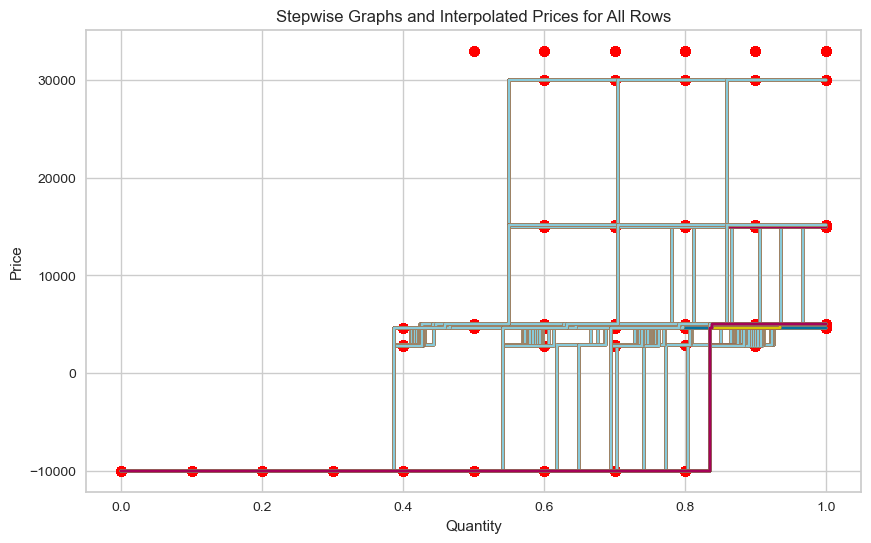

In [82]:
# Plot all stepwise curves on a single graph
plt.figure(figsize=(10, 6))

for quantities, prices, intp_quantities, intp_prices in tqdm(zip(all_quantities, all_prices, all_intp_quantities, all_intp_prices), total=len(all_quantities), desc='Processing'):
    plt.step(quantities, prices, where='pre')
    plt.scatter(intp_quantities, intp_prices, color='red')

# Customize the plot as needed
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Stepwise Graphs and Interpolated Prices for All Rows')
plt.legend()
plt.show()

# K-Means Clustering

In [21]:
# Create a DataFrame with the original data and cluster labels
price_series_df = pd.DataFrame(price_series, columns=[f'Feature_{i+1}' for i in range(price_series.shape[1])])

In [22]:
price_series_df.shape

(101396, 11)

## Identify best number of clusters

In [23]:
wcss = {} ## Within-Cluster Sum of Square
ssc = {}
calinski_score = {}
davies_score = {}
K = range(2,16)

for k in tqdm(K, desc='Clustering Progress'):
    #Building and fitting the model
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(price_series_df)
    kmeans_model.fit(price_series_df)

    wcss[k] = kmeans_model.inertia_ ### sum of squared distances to closest cluster center
    ssc[k] = silhouette_score(price_series_df, kmeans_model.labels_, metric='euclidean')
    davies_score[k] = davies_bouldin_score(price_series_df, kmeans_model.labels_)

Clustering Progress: 100%|██████████| 14/14 [21:24<00:00, 91.75s/it]


### Visual Method

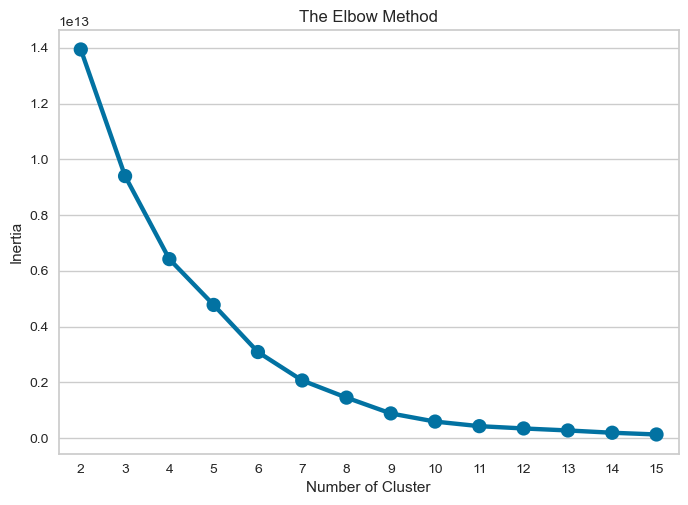

In [28]:
# Check results of elbow method

plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [25]:
# Locate the knee or elbow
cost_kneed = KneeLocator(x = K , y = list(wcss.values()) , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
suggested_cluster = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(suggested_cluster))

Elbow at k = 6 clusters


### Mathematical Method

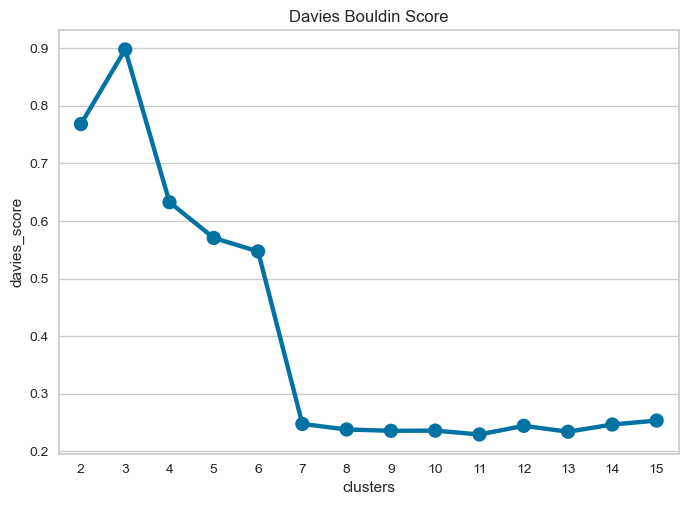

In [29]:
# Create plot for Davies-Bouldin score

plt.title('Davies Bouldin Score')
plt.xlabel('clusters')
plt.ylabel('davies_score')
sns.pointplot(x=list(davies_score.keys()), y=list(davies_score.values()))
plt.show()

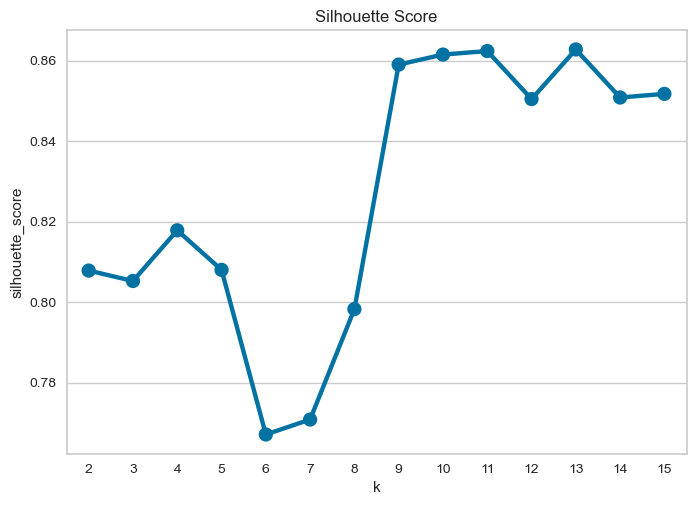

In [31]:
# Create plot for silhouette score

plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('silhouette_score')
sns.pointplot(x=list(ssc.keys()), y=list(ssc.values()))
plt.show()

In [39]:
# Create function for silhouette plot

def silhouette_plot(X , n_list):
    silhouette_scores = []
    for k in tqdm(n_list, desc='Progress'):
        #Instantiate model in k clusters
        model = KMeans(n_clusters = k, random_state=42, n_init=10)
        #Instantiate Visualizer model of with k clusters
        visualizer = SilhouetteVisualizer(model)
        #Fit data to the model
        visualizer.fit(X)
        #Draw data
        visualizer.poof()
        #Append score
        silhouette_scores.append([visualizer.silhouette_score_ , k])
    return silhouette_scores

Progress:   0%|          | 0/1 [00:00<?, ?it/s]

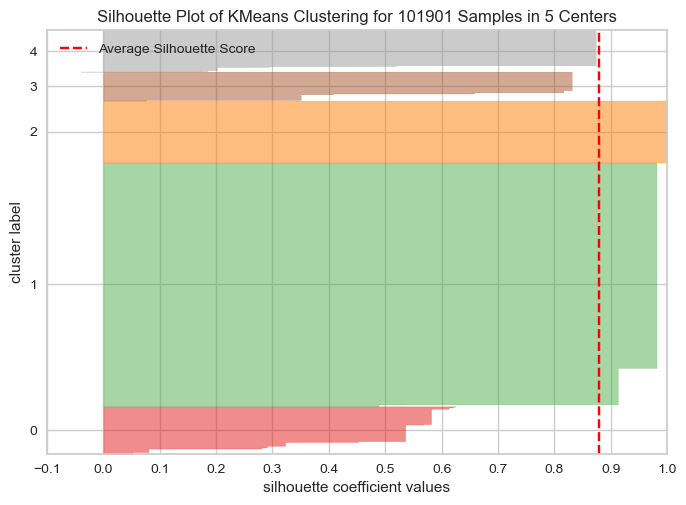

Progress: 100%|██████████| 1/1 [04:08<00:00, 248.48s/it]


[[0.8795360453776871, 5]]

In [40]:
# Create silhouette plot

k_cluster_test = [5]

silhouette_plot(price_series_df , k_cluster_test)

## Clustering with chosen k

In [64]:
# Number of clusters (you can choose an appropriate value for your case)
n_clusters = 4

# Initialize K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(price_series)

# Get cluster labels
cluster_labels = kmeans.labels_
cluster_labels = cluster_labels + 1

C:\Users\berna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [65]:
# Declare your own custom palette with 7 colors
custom_palette = ["#227c9d", "#48cfae", "#4fc0e8", "#fe6d73", "#ffcb77", "#ff66c4"]

# Use the custom palette with only the first 5 colors
cluster_palette = sns.color_palette(custom_palette[:n_clusters])

### Snake plot

C:\Users\berna\AppData\Local\Temp\ipykernel_13116\58466227.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None, palette=cluster_palette)


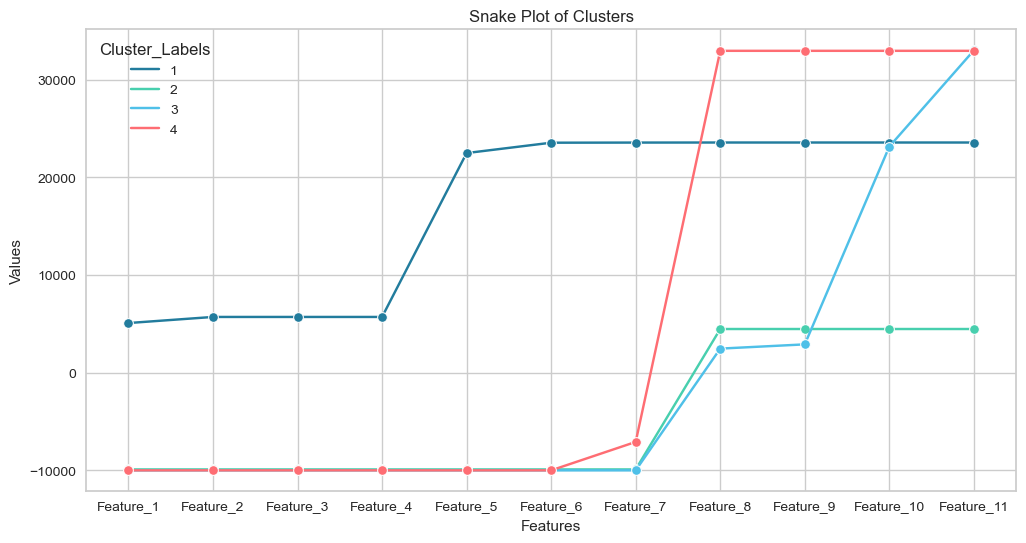

In [66]:
price_series_df['Cluster_Labels'] = cluster_labels

# Melt the DataFrame for the snake plot
df_melted = pd.melt(price_series_df, id_vars='Cluster_Labels', value_vars=price_series_df.columns[:-1])

# Create a snake plot using seaborn with specified color palette
plt.figure(figsize=(12, 6))
sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None, palette=cluster_palette)
plt.title('Snake Plot of Clusters')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

### TSNE graph

<Axes: title={'center': 'Flattened Graph of 5 Clusters'}>

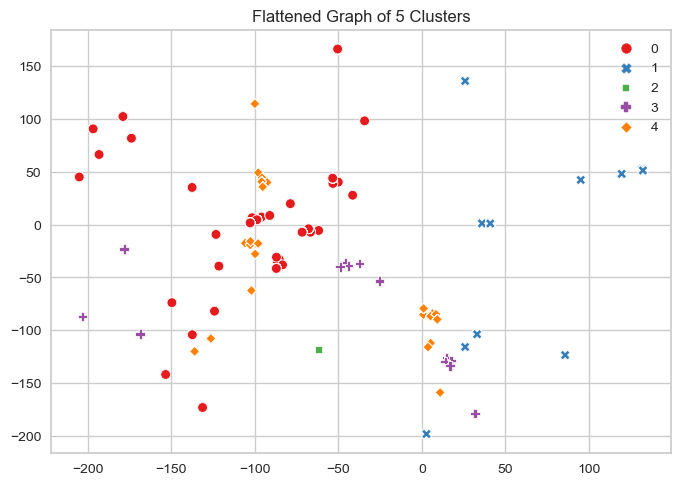

In [55]:
# Initialise TSNE
model = TSNE(random_state=1)
transformed = model.fit_transform(price_series_df)

# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(n_clusters))
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

### Count plot

C:\Users\berna\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


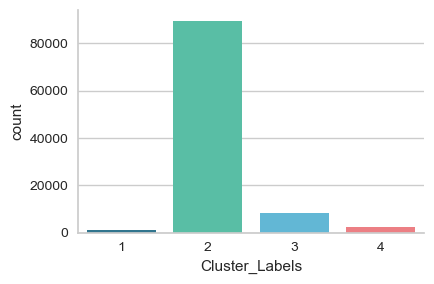

In [67]:
sns.catplot(
    data=price_series_df,
    x="Cluster_Labels",
    kind="count",
    palette=cluster_palette,
    height = 3,
    aspect = 1.5
  )
plt.show()

In [45]:
# Number of clusters (you can choose an appropriate value for your case)
n_clusters = 4

# Initialize K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(price_series)

# Get cluster labels
cluster_labels = kmeans.labels_

C:\Users\berna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Snake Plot

C:\Users\berna\AppData\Local\Temp\ipykernel_10252\3315188144.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None)


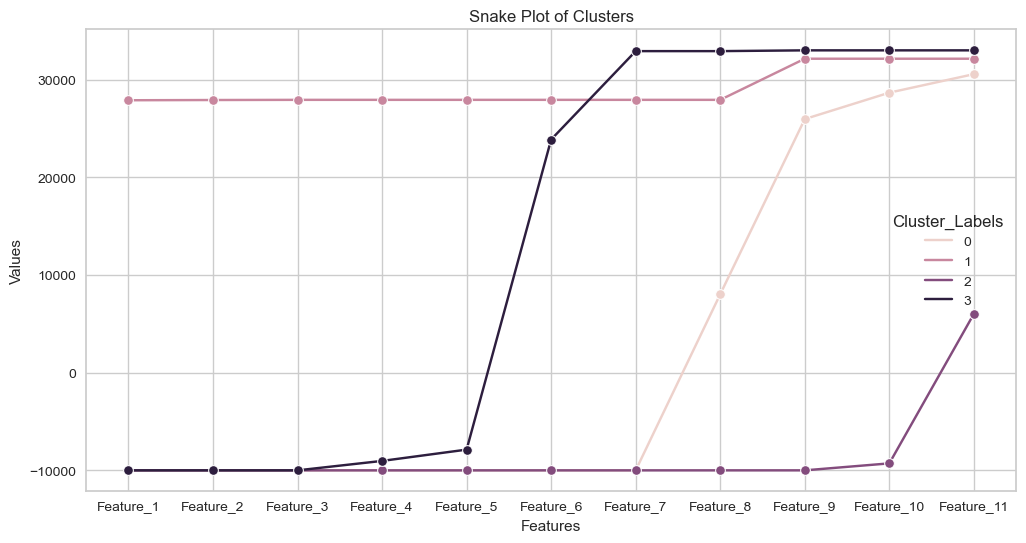

In [46]:
price_series_df['Cluster_Labels'] = cluster_labels

# Melt the DataFrame for the snake plot
df_melted = pd.melt(price_series_df, id_vars='Cluster_Labels', value_vars=price_series_df.columns[:-1])

# Create a snake plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None)
plt.title('Snake Plot of Clusters')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

#### TSNE graph

<Axes: title={'center': 'Flattened Graph of 4 Clusters'}>

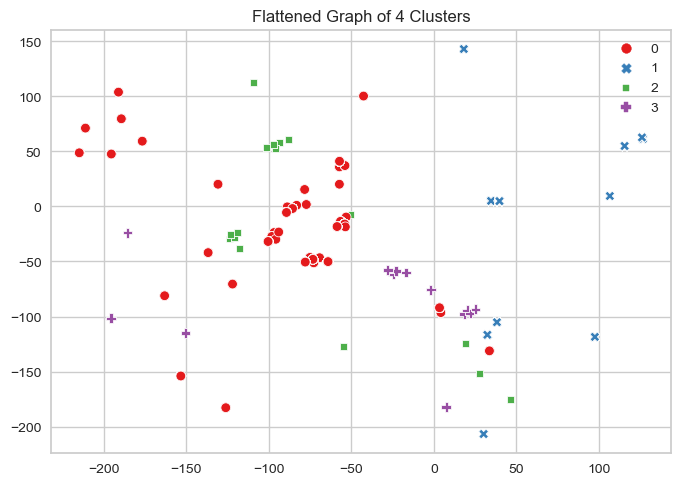

In [47]:
# Initialise TSNE
model = TSNE(random_state=1)
transformed = model.fit_transform(price_series_df)

# Plot t-SNE
plt.title('Flattened Graph of {} Clusters'.format(n_clusters))
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

#### Count plot

C:\Users\berna\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


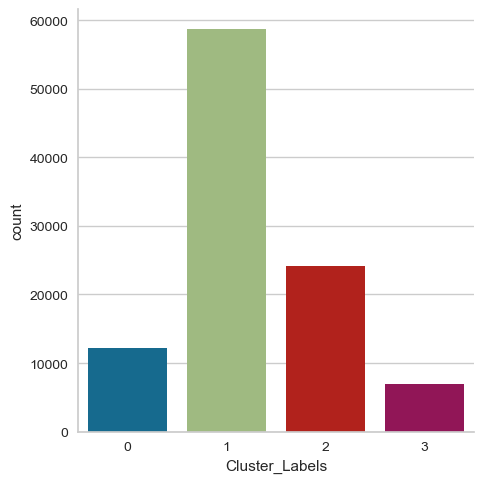

In [48]:
sns.catplot(
    data=price_series_df,
    x="Cluster_Labels",
    kind="count"
  )
plt.show()

In [ ]:
# There really is a cluster that dominates. We will stick with K = 5 since the metrcis are good for that.

## Stepwise Clustering

100%|██████████| 4/4 [00:12<00:00,  3.16s/it]


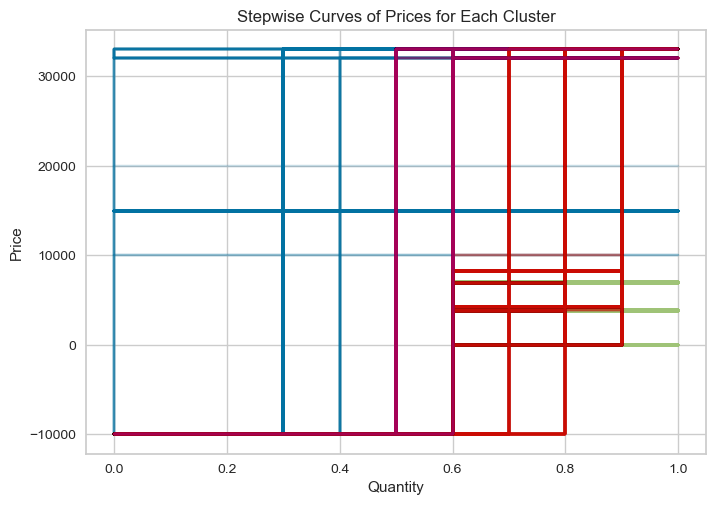

In [39]:
# Define the quantity step
quantity_step = 0.1

# Define the range of quantities from 0 to 1 with the specified step
quantities = np.arange(0, 1.1, quantity_step)

# Extract the price columns
price_columns = [f'Feature_{i}' for i in range(1, 12)]

# Group by cluster labels
grouped_clusters = price_series_df.groupby('Cluster_Labels')

# Plot stepwise curves for each cluster
for cluster, group in tqdm(grouped_clusters):
    # Select the first 10000 curves or all if less than 10000
    group = group.head(10000) if len(group) >= 10000 else group
    
    # Plot stepwise curves
    for index, row in group.iterrows():
        prices = row[price_columns]
        plt.step(quantities, prices, where='pre', color=f'C{cluster}', alpha=0.1, label=f'Cluster {cluster}')

# Customize the plot
plt.xlabel('Quantity')
plt.ylabel('Price')
#plt.legend(title='Clusters')
plt.title('Stepwise Curves of Prices for Each Cluster')
plt.show()


## Time Distribution Attempt

### Create a separate time distribution dataframe

In [68]:
time_distribution = df_2022.copy()

In [69]:
time_distribution.reset_index(drop=True, inplace=True)
time_distribution.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,01/01/2022,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,01/01/2022 12:05:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,01/01/2022 12:10:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,01/01/2022 12:15:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,01/01/2022 12:20:00 AM,-10000.0,-10000.0,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,3835.4,...,0.606403,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [70]:
time_distribution = time_distribution[['run_time', 'price1']]
time_distribution.head()

,run_time,price1
0,01/01/2022,-10000.0
1,01/01/2022 12:05:00 AM,-10000.0
2,01/01/2022 12:10:00 AM,-10000.0
3,01/01/2022 12:15:00 AM,-10000.0
4,01/01/2022 12:20:00 AM,-10000.0


In [71]:
# Assuming df is your DataFrame
split_values = time_distribution['run_time'].str.split(' ', n=1, expand=True)
time_distribution['date'] = split_values[0]
time_distribution['time'] = split_values[1].fillna('12:00:00 AM')
time_distribution.head()

,run_time,price1,date,time
0,01/01/2022,-10000.0,01/01/2022,12:00:00 AM
1,01/01/2022 12:05:00 AM,-10000.0,01/01/2022,12:05:00 AM
2,01/01/2022 12:10:00 AM,-10000.0,01/01/2022,12:10:00 AM
3,01/01/2022 12:15:00 AM,-10000.0,01/01/2022,12:15:00 AM
4,01/01/2022 12:20:00 AM,-10000.0,01/01/2022,12:20:00 AM


In [72]:
time_distribution = time_distribution.drop(columns = ['run_time', 'price1'])
time_distribution.head()

,date,time
0,01/01/2022,12:00:00 AM
1,01/01/2022,12:05:00 AM
2,01/01/2022,12:10:00 AM
3,01/01/2022,12:15:00 AM
4,01/01/2022,12:20:00 AM


In [73]:
time_distribution['cluster_labels'] = cluster_labels
time_distribution.head()

,date,time,cluster_labels
0,01/01/2022,12:00:00 AM,2
1,01/01/2022,12:05:00 AM,2
2,01/01/2022,12:10:00 AM,2
3,01/01/2022,12:15:00 AM,2
4,01/01/2022,12:20:00 AM,2


In [74]:
#time_distribution['date'] = pd.to_datetime(time_distribution['date'])
#-- didn't push through with converting the date column to datetime kasi for some reason nawawala yung ibang months (see above block)

time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%I:%M:%S %p')
time_distribution['time'] = time_distribution['time'].dt.time

time_distribution.head()

,date,time,cluster_labels
0,01/01/2022,00:00:00,2
1,01/01/2022,00:05:00,2
2,01/01/2022,00:10:00,2
3,01/01/2022,00:15:00,2
4,01/01/2022,00:20:00,2


In [75]:
time_distribution['date'].value_counts()

date
12/20/2022    318
8/28/2022     288
9/5/2022      288
9/4/2022      288
9/3/2022      288
             ... 
03/31/2022    151
12/28/2022    100
01/19/2022     96
07/20/2022     96
01/08/2022     36
Name: count, Length: 358, dtype: int64

In [76]:
time_distribution['time'].value_counts()

time
18:20:00    385
18:05:00    354
21:15:00    354
05:35:00    354
05:30:00    354
           ... 
13:05:00    348
12:35:00    348
12:30:00    348
12:25:00    348
12:00:00    348
Name: count, Length: 288, dtype: int64

In [77]:
time_distribution['date'] = pd.to_datetime(time_distribution['date'])
time_distribution['date'].value_counts()

date
2022-12-20    318
2022-08-28    288
2022-09-05    288
2022-09-04    288
2022-09-03    288
             ... 
2022-03-31    151
2022-12-28    100
2022-01-19     96
2022-07-20     96
2022-01-08     36
Name: count, Length: 358, dtype: int64

In [78]:
time_distribution['month_year'] = time_distribution['date'].dt.to_period('M')
time_distribution['month_year'].value_counts()

month_year
2022-10    8927
2022-05    8910
2022-08    8907
2022-11    8639
2022-04    8624
2022-09    8615
2022-06    8551
2022-12    8312
2022-02    8064
2022-01    8028
2022-03    7927
2022-07    7892
Freq: M, Name: count, dtype: int64

In [79]:
# Convert time into number of minutes since 0:00:00
time_distribution['time'] = time_distribution['time'].astype(str)
time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%H:%M:%S').dt.time
time_distribution['time_minutes'] = time_distribution['time'].apply(lambda x: x.hour * 60 + x.minute)

C:\Users\berna\AppData\Local\Temp\ipykernel_13116\2381271806.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


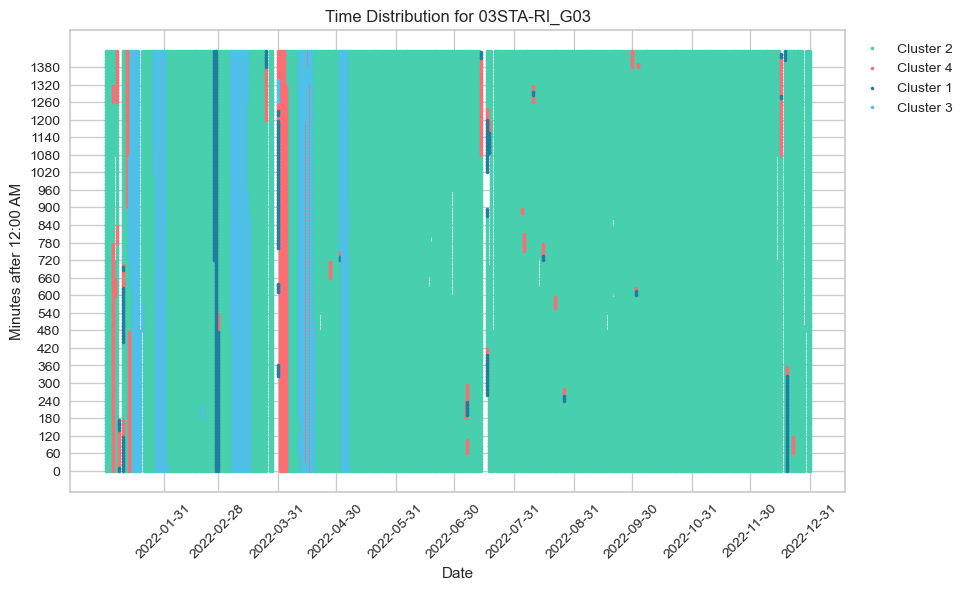

In [81]:
# Plot scatter plot with specified color palette
plt.figure(figsize=(10, 6))

unique_cluster_labels = time_distribution['cluster_labels'].unique()

for cluster_labels in unique_cluster_labels:
    cluster_data = time_distribution[time_distribution['cluster_labels'] == cluster_labels]
    
    # Adjust cluster_labels indexing to start from 0
    cluster_labels -= 1
    
    plt.scatter(
        cluster_data['date'],
        cluster_data['time_minutes'],
        label=f'Cluster {cluster_labels + 1}',  # Adjust label display
        s=5,
        c=cluster_palette[cluster_labels % len(cluster_palette)]
    )

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Minutes after 12:00 AM')
plt.title('Time Distribution for 03STA-RI_G03') # remember to change powerplant name

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

x_ticks = time_distribution['month_year'].unique()  
y_ticks = time_distribution['time_minutes'].unique()[::12]  
plt.xticks(x_ticks, rotation=45)
plt.yticks(y_ticks)

# Show the plot
plt.show()

In [62]:
# Generate a range of expected dates
expected_dates = pd.date_range(start='2022-01-01', end='2022-12-31')

# Find missing dates by comparing the expected dates with the actual dates
missing_dates = expected_dates[~expected_dates.isin(time_distribution['date'].unique())]

# Print the missing dates
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2022-01-09', '2022-03-26', '2022-03-29', '2022-03-30',
               '2022-07-15', '2022-07-16', '2022-12-17'],
              dtype='datetime64[ns]', freq=None)
